<a href="https://colab.research.google.com/github/RaviKcse08/datascience_projs/blob/main/FeedForwardNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py
import os
# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0  1506k      0 --:--:-- --:--:-- --:--:-- 1506k
Cloning into 'simulated-data-transformed'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 189 (delta 0), reused 3 (delta 0), pack-reused 186
Receiving objects: 100% (189/189), 70.08 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (184/184), done.


In [18]:
#data loading
import pandas as pd
transactions_df = pd.read_csv('final_dataset_fd.csv') 
transactions_df.tail()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
288057,288057,288057,2023-03-30 23:56:58,818,7690,48.92,2591818,29,0,0,...,23.0,55.323043,111.0,64.426306,2.0,0.0,9.0,0.0,34.0,0.0
288058,288058,288058,2023-03-30 23:57:38,3763,7460,99.06,2591858,29,0,0,...,12.0,99.681667,67.0,96.397761,2.0,0.0,8.0,0.0,23.0,0.0
288059,288059,288059,2023-03-30 23:57:39,2000,8998,83.24,2591859,29,0,0,...,11.0,87.019091,30.0,83.261000,3.0,0.0,10.0,0.0,22.0,0.0
288060,288060,288060,2023-03-30 23:58:01,2566,6688,109.55,2591881,29,0,0,...,13.0,92.094615,40.0,95.202250,1.0,0.0,1.0,0.0,17.0,0.0
288061,288061,288061,2023-03-30 23:58:13,1274,4535,79.02,2591893,29,0,0,...,6.0,48.903333,41.0,52.121220,0.0,0.0,3.0,0.0,19.0,0.0


In [23]:
DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: user 391 ms, sys: 279 ms, total: 670 ms
Wall time: 673 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [25]:
# Setting the starting day for the training period, and the deltas
import datetime
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)
# By default, scaling the input data
(train_df, test_df)=scaleData(train_df,test_df,input_features)

In [26]:
import torch

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cpu


In [27]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [28]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_test = torch.FloatTensor(test_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_test = torch.FloatTensor(test_df[output_feature].values)

In [29]:
class FraudDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        if self.y is not None:
            return self.x[index].to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.x[index].to(DEVICE)

In [30]:
train_loader_params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}
test_loader_params = {'batch_size': 64,
          'num_workers': 0}

# Generators

training_set = FraudDataset(x_train, y_train)

testing_set = FraudDataset(x_test, y_test)


training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_loader_params)

In [31]:
%%capture

fig_activation, axs = plt.subplots(3, 2,figsize=(11, 13))

input_values = torch.arange(-5, 5, 0.05)

#linear activation
output_values = input_values
axs[0, 0].plot(input_values, output_values)
axs[0, 0].set_title('Linear')
axs[0, 0].set_ylim([-5.1,5.1])

#heavyside activation
output_values = input_values>0
axs[0, 1].plot(input_values, output_values)
axs[0, 1].set_title('Heavyside (perceptron)')
axs[0, 1].set_ylim([-0.1,1.1])

#sigmoid activation
activation = torch.nn.Sigmoid()
output_values = activation(input_values)
axs[1, 0].plot(input_values, output_values)
axs[1, 0].set_title('Sigmoid')
axs[1, 0].set_ylim([-1.1,1.1])

#tanh activation
activation = torch.nn.Tanh()
output_values = activation(input_values)
axs[1, 1].plot(input_values, output_values)
axs[1, 1].set_title('Tanh')
axs[1, 1].set_ylim([-1.1,1.1])

#relu activation
activation = torch.nn.ReLU()
output_values = activation(input_values)
axs[2, 0].plot(input_values, output_values)
axs[2, 0].set_title('ReLU')
axs[2, 0].set_ylim([-0.5,5.1])

#leaky relu activation
activation = torch.nn.LeakyReLU(negative_slope=0.05)
output_values = activation(input_values)
axs[2, 1].plot(input_values, output_values)
axs[2, 1].set_title('Leaky ReLU')
axs[2, 1].set_ylim([-0.5,5.1])

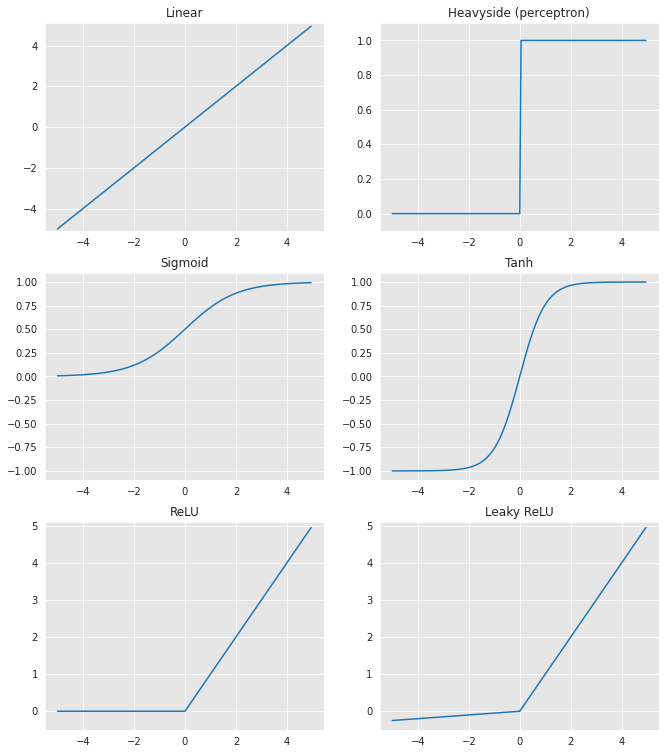

In [32]:
fig_activation

In [33]:
class SimpleFraudMLP(torch.nn.Module):
    
        def __init__(self, input_size, hidden_size):
            super(SimpleFraudMLP, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size
            
            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            
            return output

In [34]:
model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)

In [35]:
criterion = torch.nn.BCELoss().to(DEVICE)

In [36]:
model.eval()

SimpleFraudMLP(
  (fc1): Linear(in_features=15, out_features=1000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [38]:
def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss
    
evaluate_model(model,testing_generator,criterion)

0.6754083200291404

In [41]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.07)

In [42]:
n_epochs = 150
#Setting the model in training mode
model.train()

#Training loop
start_time=time.time()
epochs_train_losses = []
epochs_test_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss=[]
    for x_batch, y_batch in training_generator:
        # Removing previously computed gradients
        optimizer.zero_grad()
        # Performing the forward pass on the current batch
        y_pred = model(x_batch)
        # Computing the loss given the current predictions
        loss = criterion(y_pred.squeeze(), y_batch)
        # Computing the gradients over the backward pass
        loss.backward()
        # Performing an optimization step from the current gradients
        optimizer.step()
        # Storing the current step's loss for display purposes
        train_loss.append(loss.item())
    
    #showing last training loss after each epoch
    epochs_train_losses.append(np.mean(train_loss))
    print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
    
    #evaluating the model on the test set after each epoch    
    val_loss = evaluate_model(model,testing_generator,criterion)    
    epochs_test_losses.append(val_loss)
    print('test loss: {}'.format(val_loss))   
    print("")
    
training_execution_time=time.time()-start_time

Epoch 0: train loss: 0.03497488212175348
test loss: 0.022849849080227306

Epoch 1: train loss: 0.026166357984035306
test loss: 0.021308790618384053

Epoch 2: train loss: 0.024859017557482262
test loss: 0.0212983976222542

Epoch 3: train loss: 0.0240894314727979
test loss: 0.020158306846311307

Epoch 4: train loss: 0.02355404483005103
test loss: 0.02000740359439673

Epoch 5: train loss: 0.023368197560268717
test loss: 0.019820423985133204

Epoch 6: train loss: 0.02255634194506699
test loss: 0.020142278301122706

Epoch 7: train loss: 0.02232551884907896
test loss: 0.019617127809462953

Epoch 8: train loss: 0.022172825037790632
test loss: 0.020476473725383484

Epoch 9: train loss: 0.02153799081937659
test loss: 0.0207260400923245

Epoch 10: train loss: 0.02135393130192028
test loss: 0.01982416778751245

Epoch 11: train loss: 0.021341243510016664
test loss: 0.01954098458595586

Epoch 12: train loss: 0.020881973035420005
test loss: 0.020257386789400575

Epoch 13: train loss: 0.0208892582401

In [43]:
evaluate_model(model,testing_generator,criterion)

0.019739257270370843

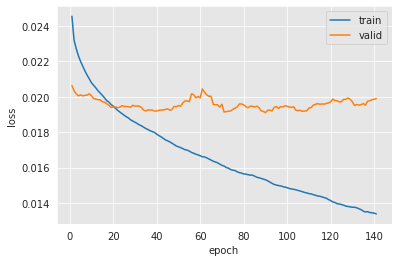

In [44]:
ma_window = 10

plt.plot(np.arange(len(epochs_train_losses)-ma_window + 1)+1, np.convolve(epochs_train_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.plot(np.arange(len(epochs_test_losses)-ma_window + 1)+1, np.convolve(epochs_test_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
#plt.ylim([0.01,0.06])

In [45]:
start_time=time.time() 
predictions_test = model(x_test.to(DEVICE))
prediction_execution_time = time.time()-start_time
predictions_train = model(x_train.to(DEVICE))
print("Predictions took", prediction_execution_time,"seconds.")

Predictions took 0.32862353324890137 seconds.


In [46]:
predictions_df=test_df
predictions_df['predictions']=predictions_test.detach().cpu().numpy()
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.871,0.643,0.281
